In [1]:
import keras
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import warnings
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
# from keras.applications.vgg19 import VGG16
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:1'#解决在epoch1时出现的未知问题

# warnings.filterwarnings('ignore')
# VGG_wights='C:/mushroomdata/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
Xception_wights='C:/mushroomdata/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
InceptionV3_wights='C:/mushroomdata/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_resnet_v2_weights='C:/mushroomdata/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
Num_classes=9

def get_features(MODEL, width, height, lambda_func=None):
    input_tensor = Input((height, width, 3))
    x = input_tensor
    #对数据进行归一化处理的函数
    if lambda_func:
        x = Lambda(lambda_func)(x)

    if MODEL==InceptionResNetV2:
        base_model = MODEL(input_tensor=x, weights=inception_resnet_v2_weights, include_top=False)
    elif MODEL==Xception:
        base_model = MODEL(input_tensor=x, weights=Xception_wights, include_top=False)
    elif MODEL==InceptionV3:
        base_model = MODEL(input_tensor=x, weights=InceptionV3_wights, include_top=False)
    
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    #之后再使用 ImageDataGenerator可以进行图像数据增强处理
    gen = ImageDataGenerator()
    # 注意 train 和 test 是图片存储路径
    # 注意 train 和 test 是图片存储路径
    train_generator = gen.flow_from_directory(r'C:/mushroomdata/train1', (width, height), shuffle=False,
                                              batch_size=1,class_mode = 'categorical',save_to_dir=r'C:/mushroomdata/train1',
                                              save_prefix='trans_',save_format='jpg')
    for i in range(1):
        train_generator.next()
    
    test_generator = gen.flow_from_directory(r'C:/mushroomdata/test1', (width, height), shuffle=False,
                                             batch_size=2,class_mode = 'categorical',save_to_dir=r'C:/mushroomdata/test1',
                                             save_prefix='tes_',save_format='jpg')

    for i in range(1):
         test_generator.next()

    #获取训练集和测试集的特征
    train_generator.reset()
    train = model.predict_generator(train_generator,train_generator.samples, verbose=1)
    test_generator.reset()
    test = model.predict_generator(test_generator,test_generator.samples, verbose=1)
    if MODEL==InceptionResNetV2:
        with h5py.File('data_InceptionResNetV2.h5','w' ) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("test", data=test)
            h.create_dataset("label", data=train_generator.classes)
    elif MODEL==Xception:
        with h5py.File('data_Xception.h5','w' ) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("test", data=test)
            h.create_dataset("label", data=train_generator.classes)
    else: 
         with h5py.File('data_InceptionV3.h5','w' ) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("test", data=test)
            h.create_dataset("label", data=train_generator.classes)

get_features(Xception, 299, 299, xception.preprocess_input)
get_features(InceptionV3, 299, 299, inception_v3.preprocess_input)
get_features(InceptionResNetV2,299, 299,inception_resnet_v2.preprocess_input)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Found 164 images belonging to 9 classes.
Found 72 images belonging to 9 classes.
72/72 [==============================] - 83s 1s/step
Found 164 images belonging to 9 classes.
Found 72 images belonging to 9 classes.
72/72 [==============================] - 41s 576ms/step
Found 164 images belonging to 9 classes.
Found 72 images belonging to 9 classes.
72/72 [==============================] - 85s 1s/step


In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *

np.random.seed(10)
X_train = []
X_test = []

for filename in ["data_Xception.h5", "data_InceptionV3.h5","data_InceptionResNetV2.h5"]:#"data_VGG16.h5"
    with h5py.File(filename, 'r') as h:
        print(h['train'].shape)#
        print(h['test'].shape)#
        print(h['label'].shape)#
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)#融合所有train特征
X_test = np.concatenate(X_test, axis=1)#融合所有模型test特征
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)#特征lable值
#shuffle将序列元素随机排布
X_train, y_train = shuffle(X_train, y_train)


(164, 2048)
(144, 2048)
(164,)
(164, 2048)
(144, 2048)
(164,)
(164, 1536)
(144, 1536)
(164,)
(164, 5632)
(144, 5632)
(164,)


In [3]:
input_tensor = Input(X_train.shape[1:])
print(input_tensor.shape)
x = Dropout(0.5)(input_tensor)
x=  Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x=  Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)
model = Model(input_tensor, x)

model.summary()
y_train = keras.utils.to_categorical(y_train, Num_classes)
model.compile(optimizer='adadelta',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=4,nb_epoch=2, validation_split=0.2)
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

(?, 5632)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5632)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1442048   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 131 samples, validate on 33 samples
Epoch 1/2
131/131 [==============================] - 6s 45ms/step - loss: 2.9925 - acc: 0.1450 - val_loss: 2.2225 - val_acc: 0.1818
Epoch 2/2
144/144 [==============================] - 2s 11ms/step


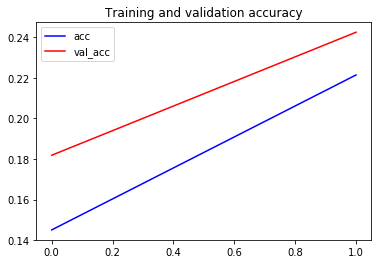

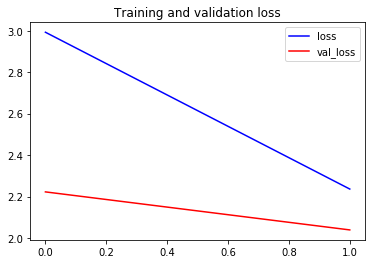

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
matplotlib.use('Qt5Agg') 
from matplotlib import pyplot as plt
%matplotlib inline

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.legend(["acc", "val_acc"], loc='best')
    plt.title('Training and validation accuracy')
    plt.show()
    loss = history.history['loss']
    val_loss = history.history['val_loss']   
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.legend(["loss", "val_loss"], loc='best')
    plt.title('Training and validation loss')
    plt.show()

plot_training(history)

In [5]:
from keras.models import load_model

# model.load_weights('best_mushroom2.hdf5')
model.save('model_mushroom2_weight.h5')